<a href="https://colab.research.google.com/github/JINYUHOON/Pneumonia-Detection/blob/main/%ED%95%84%EC%82%AC%EC%A6%89%EC%83%9D%ED%96%89%EC%83%9D%EC%A6%89%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing and importing libraries
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install sklearn
!pip install h5py pyyaml
!pip install tf_nightly
!pip install tensorboardcolab

import matplotlib.pyplot as plt
import numpy as np
import PIL
from imageio import imsave
from PIL import Image
from statistics import stdev 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

data_dir = '/content/drive/MyDrive/3차플젝drive/__Semantic_segmentation/TEST_FOLDER/'

train_dir = os.path.join(data_dir, "Converted_Images_PNG")
val_dir = os.path.join(data_dir, "val_img")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

225 20


In [ ]:
import glob
import pandas as pd


mask_filenames = glob.glob('/content/drive/MyDrive/3차플젝drive/__Semantic_segmentation/TEST_FOLDER/Merged_Masks_PNG/*')
mask_df = pd.DataFrame()
mask_df['filename'] = mask_filenames
mask_df['mask_percentage'] = 0
mask_df['labels'] = 0
mask_df.set_index('filename', inplace=True)

for file in mask_filenames:
    mask_df.loc[file, 'mask_percentage'] = np.array(Image.open(file)).sum()/(128*128*255)

# mask_df.loc[mask_df.mask_percentage > 0, 'labels'] = 1

In [ ]:
from sklearn.model_selection import train_test_split

train_valid_filenames = glob.glob('/content/drive/MyDrive/3차플젝drive/__Semantic_segmentation/TEST_FOLDER/Converted_Images_PNG/*')

train_filenames, valid_filenames = train_valid_filenames[:200], train_valid_filenames[200:]
# mask_train_filenames = [f.replace('/Converted_Images_PNG', '/preprocessing_complete_img') for f in train_filenames]
# mask_valid_filenames = [f.replace('/Converted_Images_PNG', '/preprocessing_complete_img') for f in valid_filenames]


mask_train_filenames = [f.replace('/Converted_Images_PNG', '/Merged_Masks_PNG') for f in train_filenames]
mask_valid_filenames = [f.replace('/Converted_Images_PNG', '/Merged_Masks_PNG') for f in valid_filenames]

In [ ]:
import cv2

train_x = np.zeros((len(train_filenames),128,128))
valid_x = np.zeros((len(valid_filenames),128,128))
train_mask_y = np.zeros((len(train_filenames),128,128))
valid_mask_y = np.zeros((len(valid_filenames),128,128))
# train_y = np.zeros((len(train_filenames)))
# valid_y = np.zeros((len(valid_filenames)))

# 훈련용  
for (index, image) in enumerate(train_filenames[:]):
    # train_x[index] = np.array(cv2.imread(image,0))
    train_x[index] = np.array(Image.open(image))
    
# 검증용  및 변병여부 
for (index, image) in enumerate(valid_filenames[:]):
    # valid_x[index] = np.array(cv2.imread(image,0))
    valid_x[index] = np.array(Image.open(image))
# 훈련용 마스크 답지  및 병변여부 
for (index, image) in enumerate(mask_train_filenames[:]):
    train_mask_y[index] = np.array(Image.open(image))
    # train_mask_y[index] = np.array(cv2.imread(image,0))
    # train_y[index] = mask_df.loc[image, 'labels']
    
# 검증용 병변 답지  및 병변여부 
for (index, image) in enumerate(mask_valid_filenames[:]):
    valid_mask_y[index] = np.array(Image.open(image))
    # valid_mask_y[index] = np.array(cv2.imread(image,0))
    # valid_y[index] = mask_df.loc[image, 'labels']

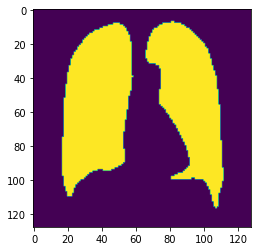

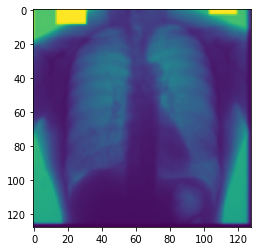

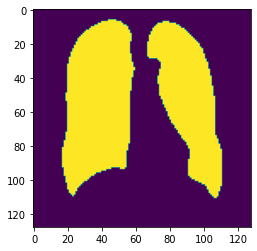

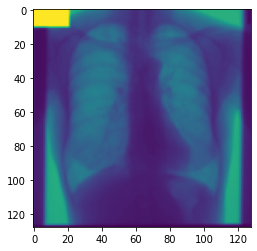

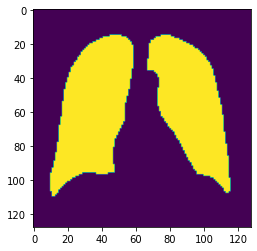

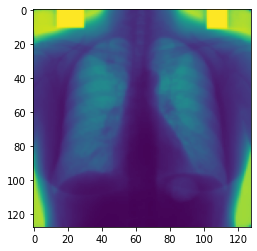

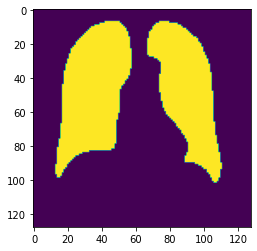

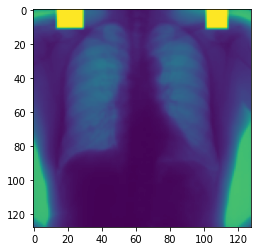

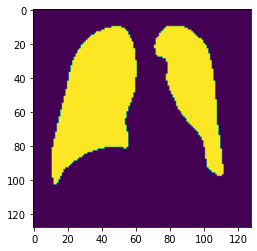

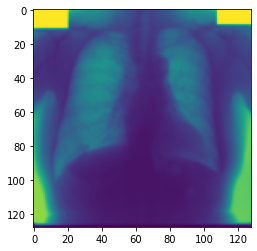

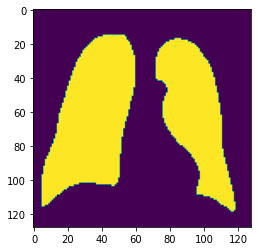

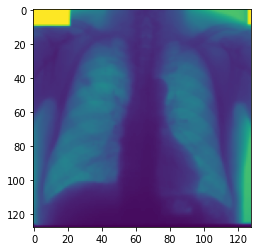

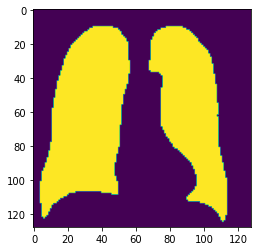

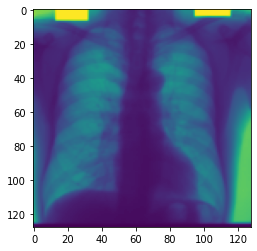

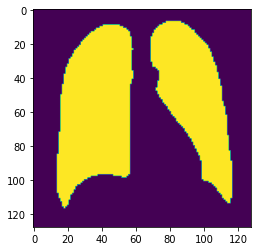

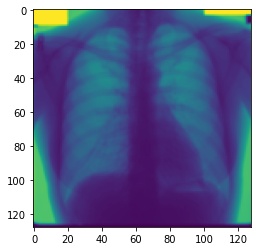

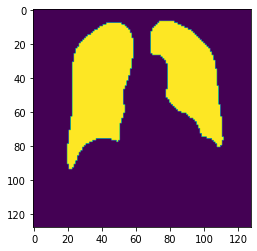

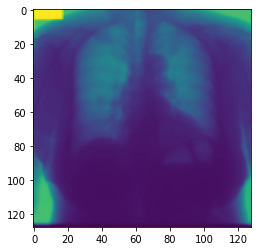

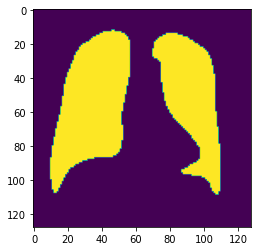

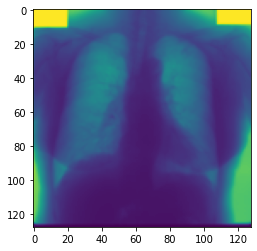

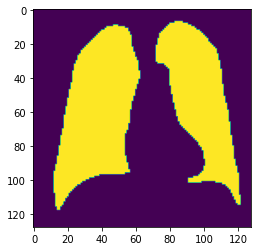

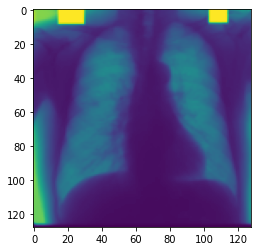

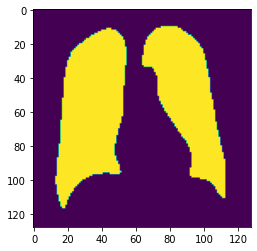

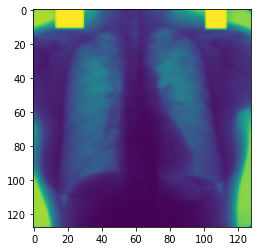

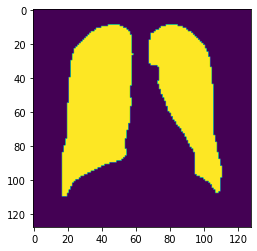

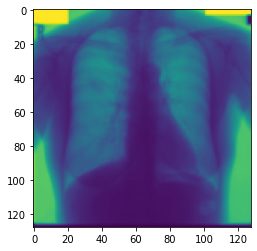

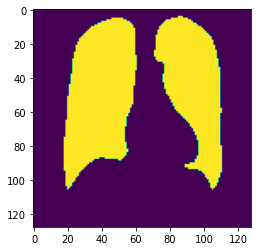

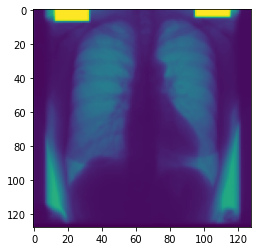

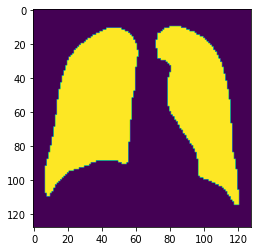

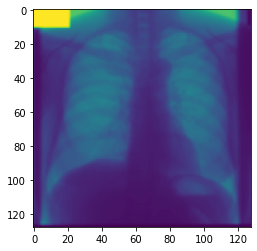

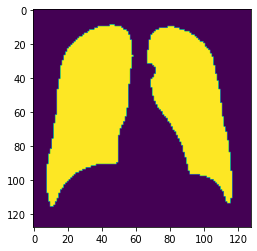

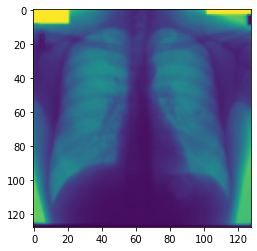

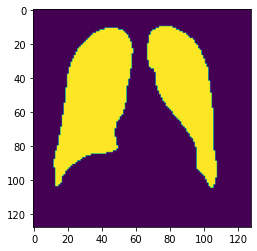

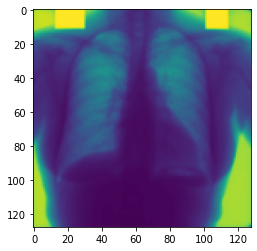

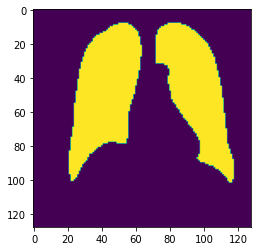

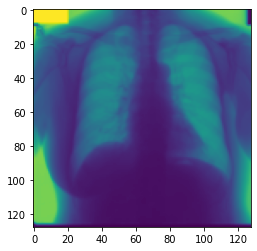

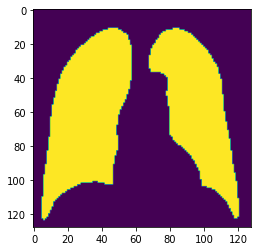

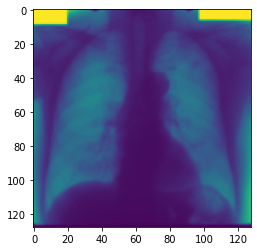

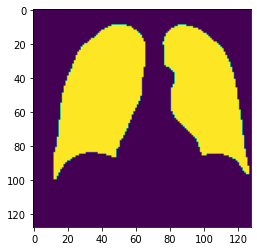

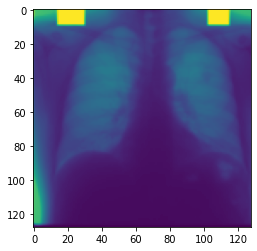

In [ ]:
for i in range(20):
    img = train_mask_y[i]
    org_img = train_x[i]

    plt.imshow(img)
    plt.show()
    plt.imshow(org_img)
    plt.show()

In [ ]:
print(train_x.shape)
print(valid_x.shape)
print(train_mask_y.shape)
print(valid_mask_y.shape)

(200, 128, 128)
(25, 128, 128)
(200, 128, 128)
(25, 128, 128)


In [ ]:
train_x = train_x.reshape(len(train_filenames),128,128,1).astype('float32') /255.
valid_x = valid_x.reshape(len(valid_filenames),128,128,1).astype('float32') /255.

train_mask_y = train_mask_y.reshape(len(train_filenames),128,128,1).astype('float32')/255.
valid_mask_y = valid_mask_y.reshape(len(valid_filenames),128,128,1).astype('float32')/255.

In [ ]:
train_mask_y[0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

In [ ]:
#Custom loss function combining categorical cross entropy and dice coefficient 
from keras import backend as K

def loss_tot(y_true, y_pred, smooth=1):
   
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    dice = (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
    
    return 1-dice+categorical_crossentropy(y_true, y_pred)                    


# 모델 1

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Dropout,MaxPooling2D,UpSampling2D, Input, ELU, concatenate, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import categorical_crossentropy


def UNet(pretrained_weights = None,input_size = (128,128,1)):
    
    inp = Input(input_size)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inp, outputs=[conv10])

    return model

model = UNet()
model.summary()
model.compile(optimizer = 'adam', loss = loss_tot, metrics = ['accuracy'])

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_228 (Conv2D)            (None, 128, 128, 64  640         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_229 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_228[0][0]']             
                                )                                                          

In [ ]:
print(train_x.shape)
print(valid_x.shape)
print(train_mask_y.shape)
print(valid_mask_y.shape)

(200, 128, 128)
(25, 128, 128)
(200, 128, 128)
(25, 128, 128)


In [ ]:
history = model.fit(train_x, train_mask_y, validation_data = (valid_x, valid_mask_y), epochs = 5, batch_size = 8, verbose = 1)

Epoch 1/5


TypeError: ignored

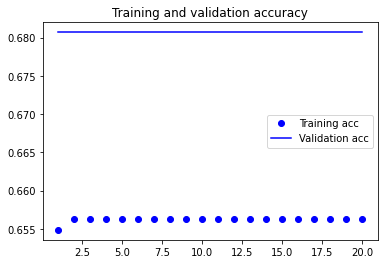

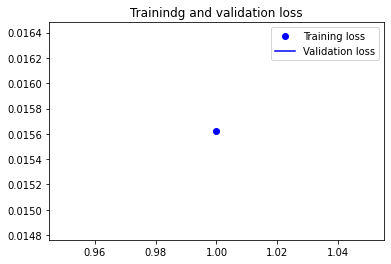

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Trainindg and validation loss')
plt.legend()
plt.show()

In [ ]:
model.predict()

In [ ]:
test_img = 

[[0.65882355 0.7921569  0.8156863  ... 0.78039217 0.7137255  0.45882353]
 [0.84313726 0.85490197 0.8666667  ... 0.8352941  0.80784315 0.7372549 ]
 [0.87058824 0.88235295 0.8901961  ... 0.8627451  0.85490197 0.8352941 ]
 ...
 [0.8627451  0.8666667  0.8745098  ... 0.84705883 0.84313726 0.83137256]
 [0.85490197 0.85882354 0.8627451  ... 0.83137256 0.8117647  0.7647059 ]
 [0.8352941  0.84313726 0.84705883 ... 0.7921569  0.74509805 0.6117647 ]]


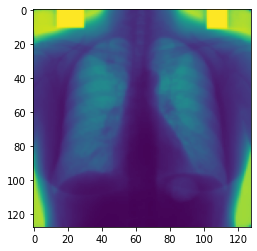

In [ ]:
#Comprovation that the data is correctly imported
plt.imshow(np.reshape(train_x[2][:][:][:],(128,128)))
print(np.reshape(train_x[2][:][:][:],(128,128)))

In [ ]:
#Build the model

#Libraries
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, Dropout,MaxPooling2D,UpSampling2D, Input, ELU, Concatenate, BatchNormalization
from keras.models import load_model
from keras.losses import categorical_crossentropy

# Model code

first_input = Input(shape =(128,128,1))
bn = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(first_input)
conv1_1 = Conv2D(128, (3,3), strides=(1, 1), activation='elu', padding="same")(bn)
conv1_2=Conv2D(128, (3,3), strides=(1, 1), activation='elu', padding="same")(conv1_1)
dropout1 = Dropout(0.1)(conv1_2)
maxPool1 = MaxPooling2D(pool_size=2, strides=1)(dropout1)
conv2_1 = Conv2D(64, (3,3), strides=(2, 2), activation='elu', padding="same")(maxPool1)
conv2_2 = Conv2D(64, (3,3), strides=(1, 1), activation='elu', padding="same")(conv2_1)
dropout2 = Dropout(0.1)(conv2_2)
maxPool2 = MaxPooling2D(pool_size=2, strides=1)(dropout2)
conv3_1 = Conv2D(32, (3,3), strides=(2, 2), activation='elu', padding="same")(maxPool2)
conv3_2 = Conv2D(32, (3,3), strides=(1, 1), activation='elu', padding="same")(conv3_1)
dropout3 = Dropout(0.1)(conv3_2)
maxPool3 = MaxPooling2D(pool_size=2, strides=1)(dropout3)

conv4_1 = Conv2D(16, (3,3), strides=(2, 2), activation='elu', padding="same")(maxPool3)
conv4_2 = Conv2D(16, (3,3), strides=(1, 1), activation='elu', padding="same")(conv4_1)
dropout4 = Dropout(0.1)(conv4_2)

upSampling1 = UpSampling2D(size=(2, 2))(dropout4)

#concatenate
conv_int5 = Conv2D(32, (3,3), strides=(1, 1), activation='elu', padding="same")(upSampling1)
concat1 = Concatenate()([dropout3, conv_int5])

conv5_1 = Conv2D(32, (3,3), strides=(1, 1), activation='elu', padding="same")(concat1)
conv5_2 = Conv2D(32, (3,3), strides=(1, 1), activation='elu', padding="same")(conv5_1)
dropout5 = Dropout(0.1)(conv5_2)
upSampling2 = UpSampling2D(size=(2, 2))(dropout5)
#concatenate
conv_int6 = Conv2D(64, (3,3), strides=(1, 1), activation='elu', padding="same")(upSampling2)
concat2 = Concatenate()([dropout2, conv_int6])

conv6_1 = Conv2D(64, (3,3), strides=(1, 1), activation='elu', padding="same")(concat2)
conv6_2 = Conv2D(64, (3,3), strides=(1, 1), activation='elu', padding="same")(conv6_1)
dropout6 = Dropout(0.1)(conv6_2)
upSampling3 = UpSampling2D(size=(2, 2))(dropout6)

#concatenate
conv_int7 = Conv2D(128, (3,3), strides=(1, 1), activation='elu', padding="same")(upSampling3)
concat3 = Concatenate()([dropout1, conv_int7])

conv7_1 = Conv2D(128, (3,3), strides=(1, 1), activation='elu', padding="same")(concat3)
conv7_2 = Conv2D(128, (3,3), strides=(1, 1), activation='elu', padding="same")(conv7_1)

dropout7 = Dropout(0.1)(conv7_2)

#batch normalization
bn = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(dropout7)

output = Conv2D(1, [1,1], strides=(1, 1), activation='softmax', padding="same")(bn)
#output2 = Conv2D(4, [1,1], strides=(1, 1), activation='softmax', padding="same")(bn)

In [ ]:
#Custom loss function combining categorical cross entropy and dice coefficient 
from tensorflow.keras import backend as K

def loss_tot(y_true, y_pred, smooth=1):
   
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    dice = (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
    
    return 1-dice+categorical_crossentropy(y_true, y_pred)                    


#Importing an existing model or compiling a newly defined one

#Define the optimizer
from tensorflow.keras.optimizers import Adam

#Parameters for loading an existing model
model_name = 'inversenet.h5'
load_existant = False

if load_existant:
    model = load_model(model_name) 

else:

    model = Model(inputs=first_input, outputs=output)
    model.compile(optimizer='Adadelta', loss=loss_tot, metrics=['acc'])
    model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 128, 128, 1)  4          ['input_6[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 conv2d_114 (Conv2D)            (None, 128, 128, 12  1280        ['batch_normalization_2[0][0]']  
                                8)                                                          

In [ ]:
#data augmentation 

# Create two instances (images and targets) with the same arguments
data_gen_args = dict(zoom_range=0.01, horizontal_flip=True, vertical_flip = True, rotation_range = 10)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

#image should have rank 4
image_datagen.fit(train_x, augment=True, seed=seed)
mask_datagen.fit(train_mask_y, augment=True, seed=seed)

image_generator = image_datagen.flow(train_x,seed=seed)

mask_generator = mask_datagen.flow(train_mask_y,seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)


In [ ]:
#Apply early stopping
from keras.callbacks import EarlyStopping, ModelCheckpoint

tbc=TensorBoardColab()#Tensorboard callback
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience = 100, verbose=0)
check_point = ModelCheckpoint('/content/drive/MyDrive/3차플젝drive/__Semantic_segmentation/check_test.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

Wait for 8 seconds...
TensorBoard link:
https://5528-34-121-178-18.ngrok.io


In [ ]:
# Train the model, iterating on the data in batches
# history = model.fit_generator(train_generator, validation_data = (Xva, Yva), verbose = 1, steps_per_epoch=10, epochs=1000, callbacks=[early_stopping , check_point, TensorBoardColabCallback(tbc)], class_weight = 'auto') #steps_per_epoch = data_size/n_batch

history = model.fit_generator(train_generator, validation_data = (valid_x, valid_mask_y), verbose = 1, steps_per_epoch=10, epochs=10)



Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


10/10 [==============================] - 57s 6s/step - loss: 0.4960 - acc: 0.0000e+00 - val_loss: 0.4963 - val_acc: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 60s 6s/step - loss: 0.4960 - acc: 0.0000e+00 - val_loss: 0.4963 - val_acc: 0.0000e+00
Epoch 3/10
 2/10 [=====>........................] - ETA: 13s - loss: 0.4960 - acc: 0.0000e+00

KeyboardInterrupt: ignored